In [2]:
# importing libraries
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

In [3]:
# Setting up the tickers
tickers = ['^GSPC', 'GC=F']

In [41]:
df = yf.download(tickers, start='2015-01-01')['Close'].dropna()

[*********************100%***********************]  4 of 4 completed


In [7]:
df

Ticker,GC=F,^GSPC
Date,,
2015-01-02,1186.000000,2058.199951
2015-01-05,1203.900024,2020.579956
2015-01-06,1219.300049,2002.609985
2015-01-07,1210.599976,2025.900024
2015-01-08,1208.400024,2062.139893
...,...,...
2025-04-08,2968.399902,4982.770020
2025-04-09,3056.500000,5456.899902
2025-04-10,3155.199951,5268.049805


In [9]:
# Log returns
ret_df = np.log(df/df.shift(1))

<Axes: xlabel='Date'>

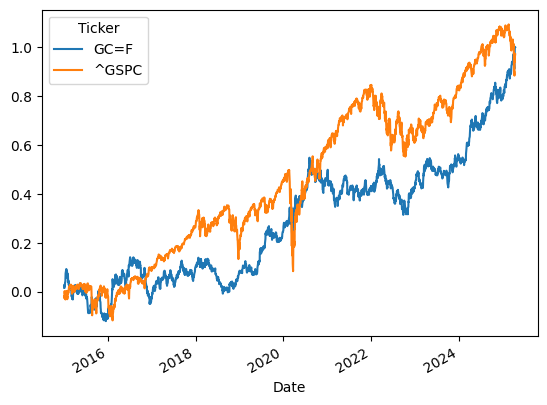

In [11]:
# Plotting the returns
ret_df.cumsum().plot()

We could see following 2020, S&P 500 provided more returns than Gold.

We are cureently assuming that the portfolio is divided equally between Gold and S&P.

In [13]:
# Making weights flexible
W = np.ones(len(ret_df.columns))/ (np.ones(len(ret_df.columns))).sum()
W

array([0.5, 0.5])

We need to find the lowest Sharpe ratio, since Sharpe ratio means adjusted returns and lowest sharpe ratio will yield better returns.

We will go ahead and create a function, that churns the sharpe ratio on the proptfolio and we will make the function flexible so we could add more assets to the portfolio.

In [16]:
# Creating the function
def sharpe_ratio(W, returns):
    pf_risk = (W.dot(returns.cov()).dot(W)) ** 0.5
    SR = W.dot(returns.mean())/pf_risk
    return -SR

sharpe_ratio(W, ret_df)

-0.05045535223781738

Sharpe ratio of equally weighted portfolio. -0.05045

The equally weighted portfolio might not be a better choice everytime. We shoud;s still seek to minimize the sharpe ratio.

In [18]:
# Providing constraints for minimization
# if the Weight is 1, the constraint will be triggered
cons = ({"type":"eq", "fun": lambda x: np.sum(x) -1})

In [51]:
results = minimize(sharpe_ratio, W, ret_df, constraints=cons)

### Let's break it down
x: [0.6177, 0.3823] likely means:

Weight 1 (Asset A) = 61.77%

Weight 2 (Asset B) = 38.23%

jac: [-4.782e-06 7.728e-06] is showing that the gradient is close to zero, which is what you want at an optimum (flat slope = local extremum).
nit: means the iterations it took

In [22]:
opt_W = results['x']

In [23]:
ret_df.dot(opt_W).cumsum()

Date
2015-01-02         NaN
2015-01-05    0.002201
2015-01-06    0.006638
2015-01-07    0.006635
2015-01-08    0.012289
                ...   
2025-04-08    0.904713
2025-04-09    0.957528
2025-04-10    0.963695
2025-04-11    0.983529
2025-04-14    0.989184
Length: 2583, dtype: float64

In [24]:
ret_df.dot(W).cumsum()

Date
2015-01-02         NaN
2015-01-05   -0.001734
2015-01-06    0.000155
2015-01-07    0.002356
2015-01-08    0.010312
                ...   
2025-04-08    0.900795
2025-04-09    0.960867
2025-04-10    0.959147
2025-04-11    0.978618
2025-04-14    0.985718
Length: 2583, dtype: float64

In [31]:
# Creating a new dataset to train
train = ret_df[:int(len(ret_df)*0.7)]
train

Ticker,GC=F,^GSPC
Date,,
2015-01-02,NaN,NaN
2015-01-05,0.014980,-0.018447
2015-01-06,0.012711,-0.008933
2015-01-07,-0.007161,0.011563
2015-01-08,-0.001819,0.017730
...,...,...
2022-03-07,0.014549,-0.029963
2022-03-08,0.022906,-0.007260
2022-03-09,-0.026927,0.025374


In [32]:
# Test dataset
test = ret_df[int(len(ret_df)*0.7):]
test

Ticker,GC=F,^GSPC
Date,,
2022-03-14,-0.011719,-0.007449
2022-03-15,-0.015998,0.021183
2022-03-16,-0.010687,0.022137
2022-03-17,0.017714,0.012272
2022-03-18,-0.007183,0.011595
...,...,...
2025-04-08,0.005777,-0.015825
2025-04-09,0.029247,0.090895
2025-04-10,0.031781,-0.035221


We will now do the optimization on train dataset and later test dataset.

In [34]:
res_train = minimize(sharpe_ratio, W, train, constraints=cons)
res_train

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.046238467981825945
       x: [ 5.215e-01  4.785e-01]
     nit: 4
     jac: [ 2.128e-05 -2.318e-05]
    nfev: 12
    njev: 4

In [35]:
test.dot(res_train['x']).cumsum()

Date
2022-03-14   -0.009676
2022-03-15   -0.007881
2022-03-16   -0.002861
2022-03-17    0.012249
2022-03-18    0.014052
                ...   
2025-04-08    0.291735
2025-04-09    0.350483
2025-04-10    0.350202
2025-04-11    0.369739
2025-04-14    0.376575
Length: 775, dtype: float64

In [36]:
test.dot(W).cumsum()

Date
2022-03-14   -0.009584
2022-03-15   -0.006992
2022-03-16   -0.001267
2022-03-17    0.013727
2022-03-18    0.015933
                ...   
2025-04-08    0.286720
2025-04-09    0.346791
2025-04-10    0.345071
2025-04-11    0.364543
2025-04-14    0.371642
Length: 775, dtype: float64

In [37]:
sharpe_ratio(res_train['x'], test)

-0.0609093204015298

In [39]:
# Sharpe ratio if we had equally weighted portfolio
sharpe_ratio(W, test)

-0.059647910789302504

Lets test this by adding another asset to the portfolio.

In [40]:
# Setting up the tickers
tickers = ['^GSPC', 'GC=F', 'TSLA', 'MMM']

In [43]:
ret_df = np.log(df/df.shift(1))

<Axes: xlabel='Date'>

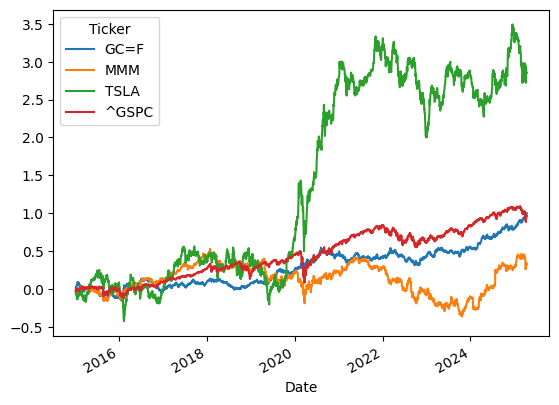

In [44]:
ret_df.cumsum().plot()

Tesla's stock clearly outperforms

In [46]:
W = np.ones(len(ret_df.columns))/ (np.ones(len(ret_df.columns))).sum()
W

array([0.25, 0.25, 0.25, 0.25])

In [47]:
sharpe_ratio(W, ret_df)

-0.038252262200469754

In [53]:
results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.055402849388269455
       x: [ 6.535e-01 -1.487e-01  6.716e-02  4.281e-01]
     nit: 13
     jac: [-2.270e-05 -1.734e-05 -1.626e-05  3.118e-05]
    nfev: 66
    njev: 13

In [55]:
ret_df = np.log(df/df.shift(1))
ret_df

Ticker,GC=F,MMM,TSLA,^GSPC
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,0.014980,-0.022811,-0.042950,-0.018447
2015-01-06,0.012711,-0.010721,0.005648,-0.008933
2015-01-07,-0.007161,0.007223,-0.001563,0.011563
2015-01-08,-0.001819,0.023685,-0.001566,0.017730
...,...,...,...,...
2025-04-08,0.005777,-0.010872,-0.050236,-0.015825
2025-04-09,0.029247,0.084124,0.204491,0.090895
2025-04-10,0.031781,-0.039446,-0.075522,-0.035221
